In [21]:
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU, Activation, Input, Embedding, Concatenate, Conv2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm.notebook import tqdm
import pickle

# **Loading CIFAR-10 Dataset**

In [22]:
((x_train, y_train), (x_test, y_test)) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Normalization of train and test sets.

In [23]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255.0
x_test /= 255.0

Random samples from training set

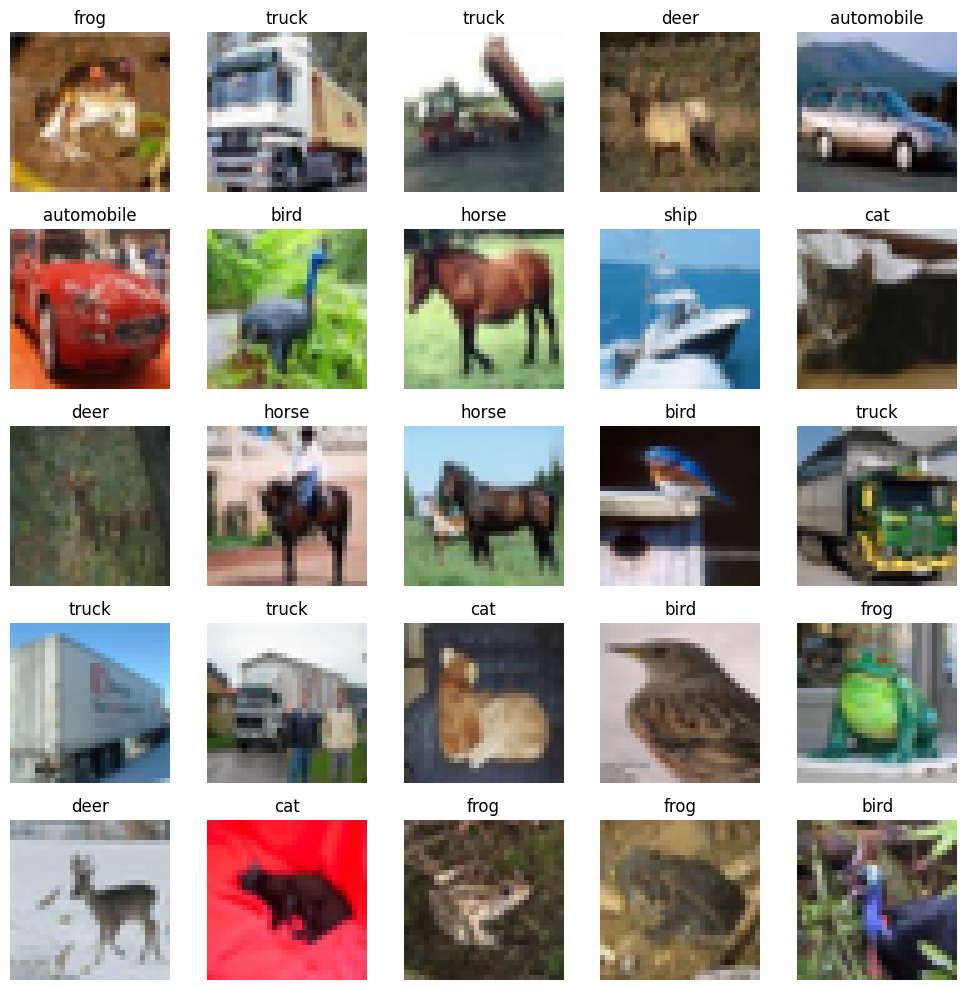

In [24]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis('off')
plt.tight_layout()
plt.show()

Random samples from testing set

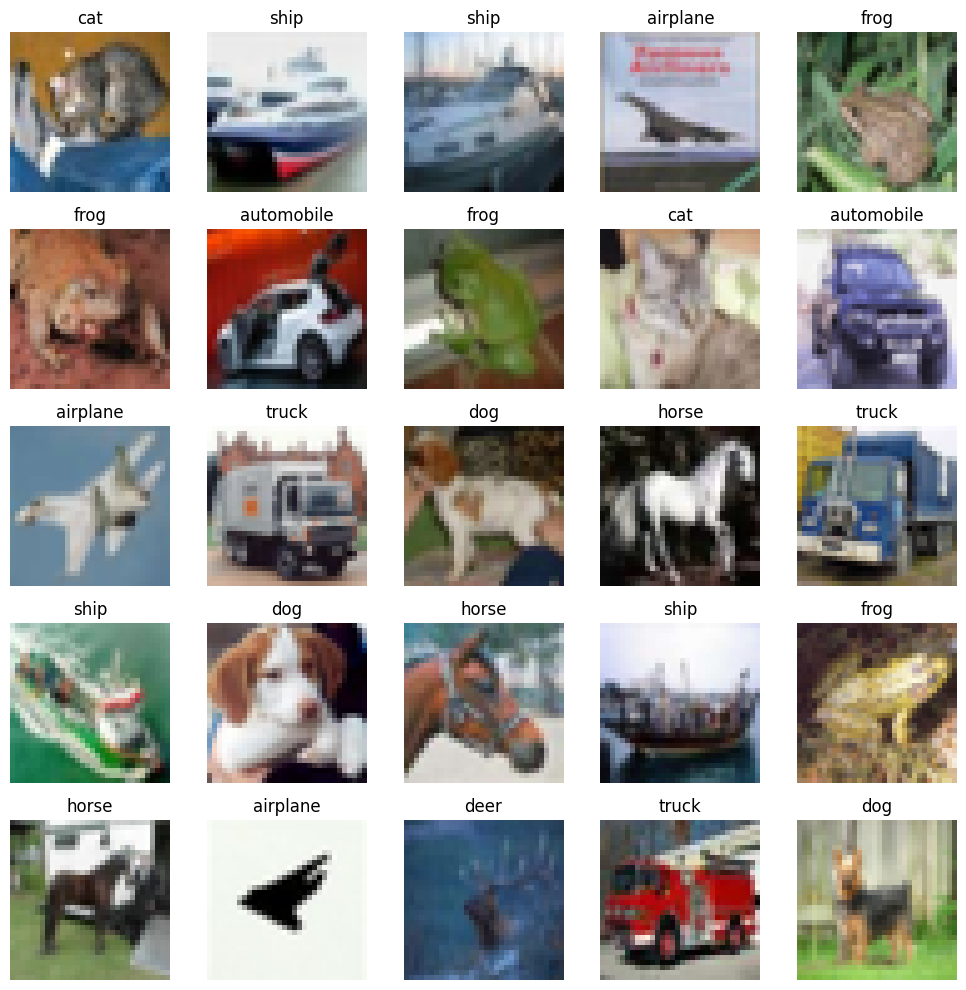

In [25]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_test[i])
    plt.title(class_names[y_test[i][0]])
    plt.axis('off')
plt.tight_layout()
plt.show()

# **Hyperparameters**

In [26]:
latent_dim = 100
num_classes = 10
epochs = 100
batch_size = 16
img_rows = 32
img_cols = 32
channels = 3
img_shape = (img_rows, img_cols, channels)
x_train = x_train * 2 - 1 # for tanh normalization

# **Building the GENERATOR**

In [27]:
def build_generator(latent_dim, num_classes):
    # Input
    noise_input = Input(shape=(latent_dim,), name='noise_input')
    label_input = Input(shape=(1,), name='label_input')

    label_embedding = Embedding(num_classes, 128)(label_input)
    label_embedding = Dense(8 * 8 * 16, use_bias=False)(label_embedding) # dimension 8x8x16
    label_embedding = Reshape((8, 8, 16))(label_embedding)

    noise_projection = Dense(8 * 8 * 112, use_bias=False)(noise_input) # dimension 8x8x112
    noise_projection = Reshape((8, 8, 112))(noise_projection)

    x = Concatenate()([noise_projection, label_embedding])

    # Upsampling block: 16x16x128
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.2)(x)

    # Upsampling block: 32x32x64
    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.2)(x)

    # Final output: 32x32x3
    output_image = Conv2D(3, (3, 3), padding='same', activation='tanh')(x)

    generator = Model(inputs=[noise_input, label_input], outputs=output_image, name='generator')
    return generator

generator = build_generator(latent_dim, num_classes)
generator.summary()


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_input         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 128)    │      1,280 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 7168)      │    716,800 │ noise_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1024)   │    131,072 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 8, 8, 112) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 8, 8, 16)  │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8, 128) │          0 │ reshape_1[0][0],  │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    262,144 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 32, 32,    │    131,072 │ leaky_re_lu[0][0] │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32, 3) │      1,731 │ leaky_re_lu_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,244,867 (4.75 MB)

 Trainable params: 1,244,483 (4.75 MB)

 Non-trainable params: 384 (1.50 KB)

# **Building the DISCRIMINATOR**

In [28]:
def build_discriminator(img_shape, num_classes):
    # Input
    img_input = Input(shape=img_shape, name='img_input')
    label_input = Input(shape=(1,), name='label_input')

    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same', name='conv1')(img_input)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dropout(0.25)(x)

    label_embedding = Embedding(num_classes, 16 * 16)(label_input)
    label_embedding = Dense(16 * 16 * 16, use_bias=False)(label_embedding)
    label_embedding = Reshape((16, 16, 16))(label_embedding)

    # Output: 16x16x48
    x = Concatenate()([x, label_embedding])

    # Output: 8x8x64
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', name='conv2')(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization()(x)

    # Output: 4x4x128
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same', name='conv3')(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    output = Dense(1, activation='sigmoid', name='discriminator_output')(x)

    discriminator = Model(inputs=[img_input, label_input], outputs=output, name='discriminator')

    return discriminator

discriminator = build_discriminator(img_shape, num_classes)
discriminator.summary()


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_input           │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 16, 16,    │        896 │ img_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 256)    │      2,560 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 16, 16,    │          0 │ conv1[0][0]       │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 4096)   │  1,048,576 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ leaky_re_lu_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 16, 16,    │          0 │ dense_2[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ dropout[0][0],    │
│ (Concatenate)       │ 48)               │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, 8, 8, 64)  │     27,712 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 8, 8, 64)  │          0 │ conv2[0][0]       │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 8, 64)  │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ dropout_1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3 (Conv2D)      │ (None, 4, 4, 128) │     73,856 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 4, 4, 128) │          0 │ conv3[0][0]       │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4, 4, 128) │          0 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 128) │        512 │ dropout_2[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discriminator_outp… │ (None, 1)         │      2,049 │ flatten[0][0]   

 Total params: 1,156,417 (4.41 MB)

 Trainable params: 1,156,033 (4.41 MB)

 Non-trainable params: 384 (1.50 KB)

In [29]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [30]:
noise_input = tf.keras.Input(shape=(latent_dim,), name='cgan_noise_input')
label_input = tf.keras.Input(shape=(1,), name='cgan_label_input')

gen_img = generator([noise_input, label_input])

discriminator_output = discriminator([gen_img, label_input])

# Create CGAN model
cgan = tf.keras.Model(inputs=[noise_input, label_input], outputs=discriminator_output, name='cgan')
cgan.compile(loss='binary_crossentropy', optimizer=generator_optimizer, metrics=['accuracy'])

In [31]:
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([tf.shape(images)[0], latent_dim])
    fake_labels = tf.random.uniform([tf.shape(images)[0], 1], minval=0, maxval=num_classes, dtype=tf.int32)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images
        generated_images = generator([noise, fake_labels], training=True)

        # Discriminator classifies real images
        discriminator.trainable = True # Ensure discriminator is trainable for its step
        real_output = discriminator([images, labels], training=True)

        # Discriminator classifies fake images
        fake_output = discriminator([generated_images, fake_labels], training=True)

        # Calculate gen/disc loss
        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output)

    # Compute and apply gradients for discriminator
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    # Compute and apply gradients for generator
    discriminator.trainable = False
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

    return disc_loss, gen_loss

# **Train the model**

Starting CGAN training...


Epoch 1/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 1/25 | D_loss: 0.4872 | G_loss: 3.3293


/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


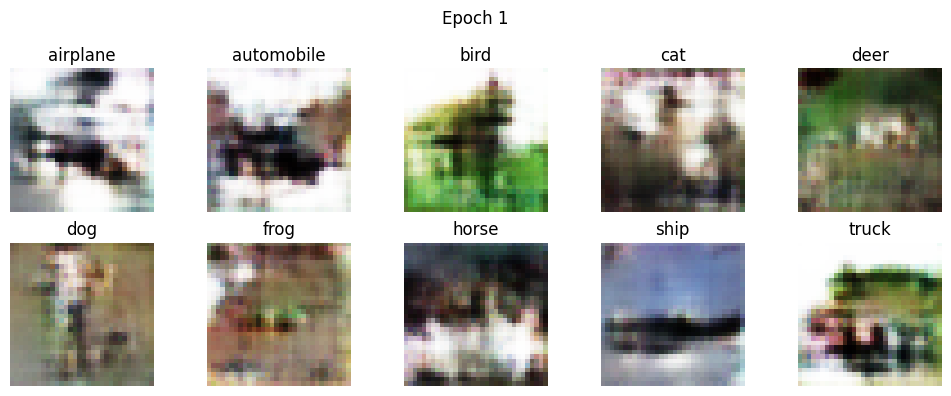

Epoch 2/25:   0%|          | 0/3125 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:789: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 2/25 | D_loss: 0.4352 | G_loss: 3.4761


/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


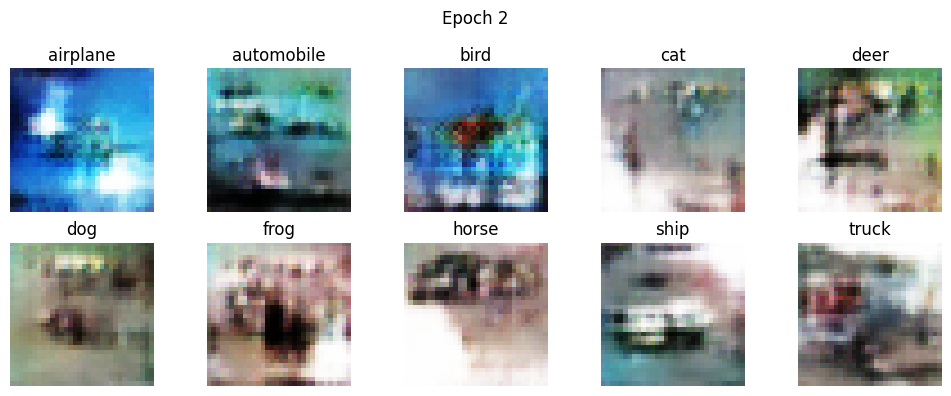

Epoch 3/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 3/25 | D_loss: 0.4635 | G_loss: 3.4868


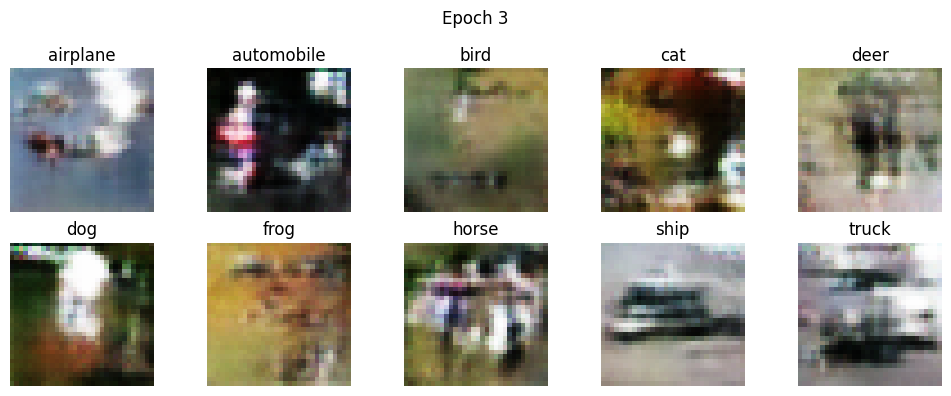

Epoch 4/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 4/25 | D_loss: 0.4437 | G_loss: 3.4777


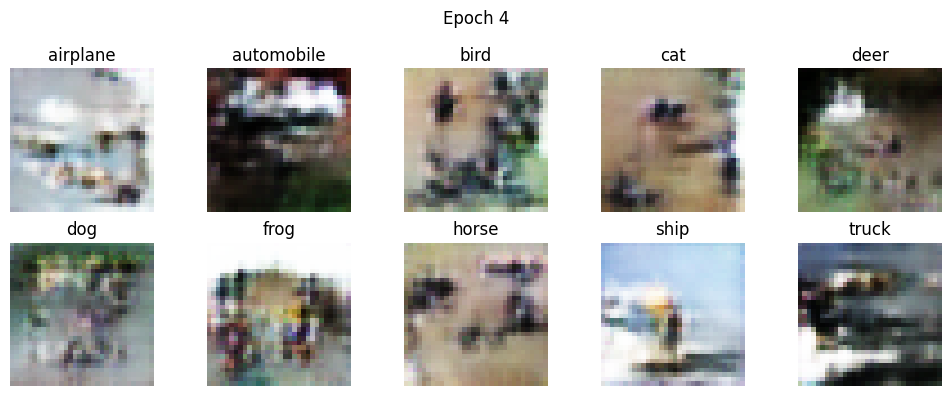

Epoch 5/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 5/25 | D_loss: 0.4869 | G_loss: 3.3398


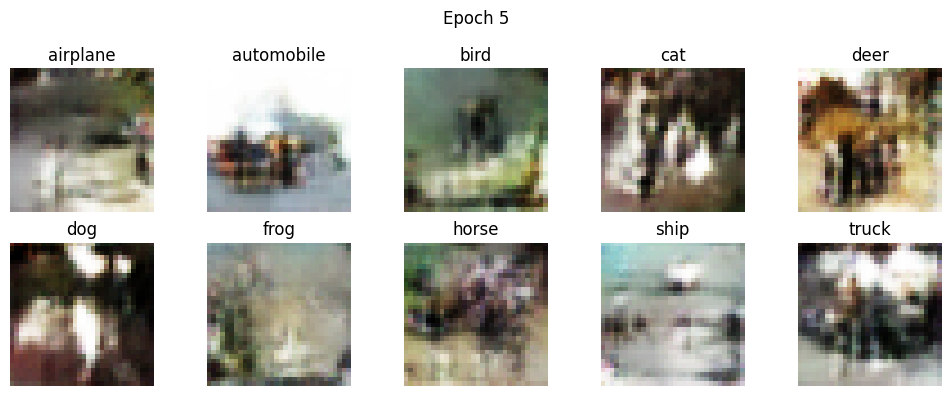

Epoch 6/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 6/25 | D_loss: 0.4784 | G_loss: 3.3168


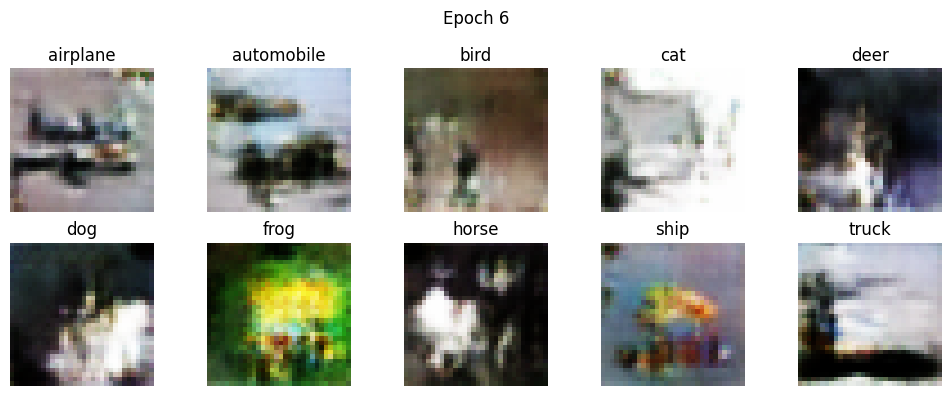

Epoch 7/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 7/25 | D_loss: 0.5324 | G_loss: 3.0864


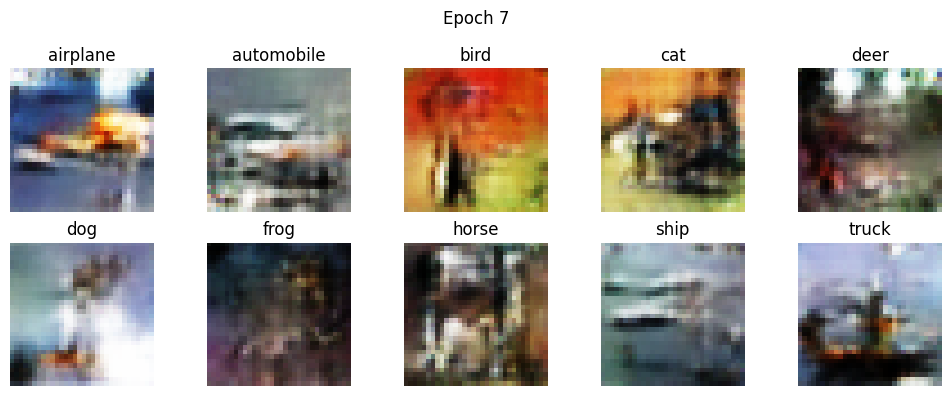

Epoch 8/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 8/25 | D_loss: 0.5298 | G_loss: 3.0665


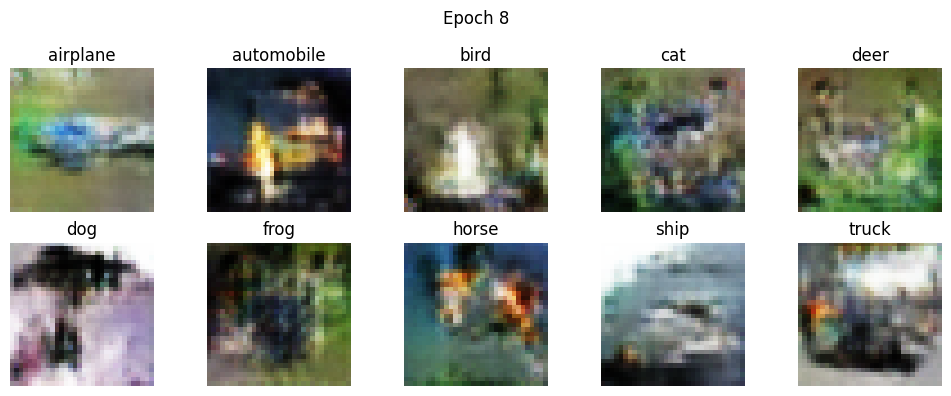

Epoch 9/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 9/25 | D_loss: 0.5581 | G_loss: 2.9045


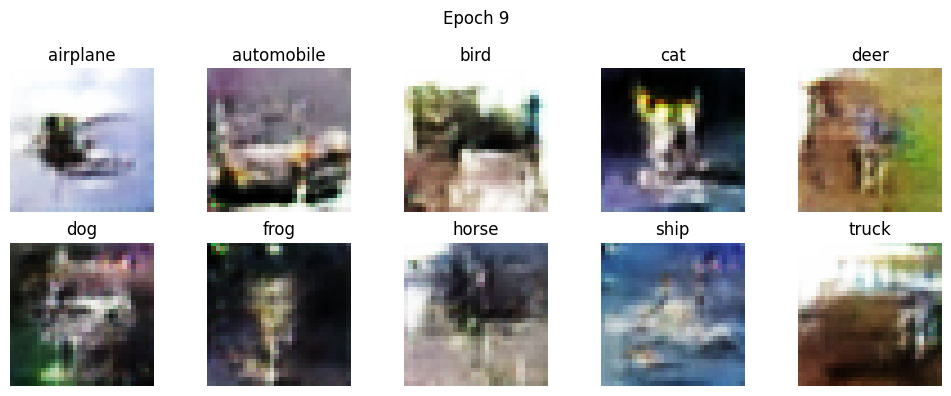

Epoch 10/25:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 10/25 | D_loss: 0.5555 | G_loss: 2.8333


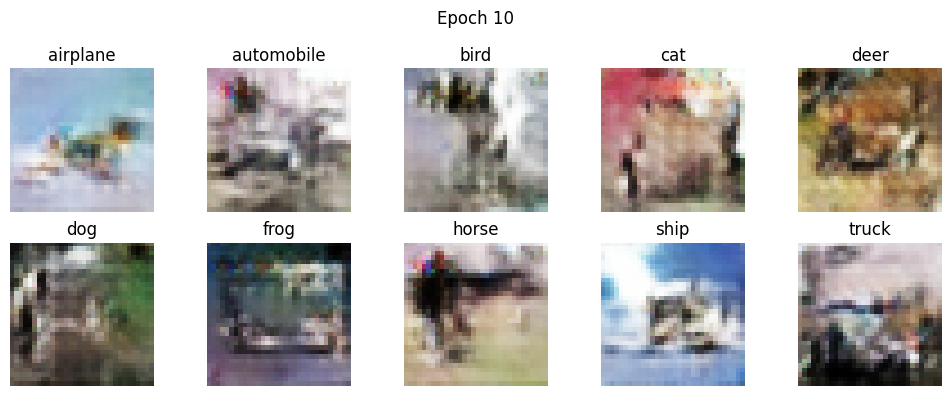

Epoch 11/25:   0%|          | 0/3125 [00:00<?, ?it/s]

In [ ]:
d_losses = []
d_accuracies = []
g_losses = []

print("Starting CGAN training...")
def save_generated_images(epoch, generator, latent_dim, num_classes, class_names):
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    sampled_labels = np.arange(0, num_classes).reshape(-1, 1)
    if r*c > num_classes:
        sampled_labels = np.tile(sampled_labels, (r*c // num_classes + 1, 1))[:r*c]

    gen_imgs = generator.predict([noise, sampled_labels], verbose=0)

    gen_imgs = 0.5 * gen_imgs + 0.5

    plt.figure(figsize=(10, 4))
    for i in range(r * c):
        plt.subplot(r, c, i + 1)
        plt.imshow(gen_imgs[i])
        plt.title(class_names[sampled_labels[i][0]])
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch}")
    plt.tight_layout()
    plt.show()


for epoch in range(epochs):
    epoch_d_loss = []
    epoch_g_loss = []

    num_batches = int(x_train.shape[0] / batch_size)

    for _ in tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{epochs}"):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_images = x_train[idx]
        real_labels = y_train[idx]

        d_loss, g_loss = train_step(real_images, real_labels)
        epoch_d_loss.append(d_loss.numpy())
        epoch_g_loss.append(g_loss.numpy())

    avg_d_loss = np.mean(epoch_d_loss)
    avg_g_loss = np.mean(epoch_g_loss)

    d_losses.append(avg_d_loss)
    g_losses.append(avg_g_loss)

    print(f"Epoch {epoch + 1}/{epochs} | D_loss: {avg_d_loss:.4f} | G_loss: {avg_g_loss:.4f}")

    save_generated_images(epoch + 1, generator, latent_dim, num_classes, class_names)

# **Save the model into a .pkl file**

In [32]:
# user needs to actually train the model as there is no saved model available right now.
with open('cgan_model.pkl', 'wb') as file:
    pickle.dump(cgan, file)
print("CGAN model saved to 'cgan_model.pkl'.")

CGAN model saved to 'cgan_model.pkl'.


# **Streamlit UI**

In [47]:
pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 71.7 MB/s eta 0:00:00
  Attempting uninstall: cachetools
    Found existing installation: cachetools 7.0.0
    Uninstalling cachetools-7.0.0:
      Successfully uninstalled cachetools-7.0.0


In [39]:
!pip install pyngrok

In [41]:
from pyngrok import ngrok
ngrok.set_auth_token('AUTHTOKEN') # Replace 'YOUR_AUTHTOKEN' with your actual ngrok authtoken
print("ngrok authtoken set. Please replace 'YOUR_AUTHTOKEN' with your actual authtoken.")

ngrok authtoken set. Please replace 'YOUR_AUTHTOKEN' with your actual authtoken.


In [55]:
%%writefile app.py
import streamlit as st
import pickle
import numpy as np
import matplotlib.pyplot as plt
import base64

st.title("CGAN Image Generator")

with open('cgan_model.pkl', 'rb') as file:
    loaded_cgan_model = pickle.load(file)

generator = loaded_cgan_model.get_layer('generator')

st.write("Generator model loaded successfully!")

latent_dim = 100

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

st.sidebar.header("Image Generation Controls")
selected_label = st.sidebar.selectbox(
    "Select a class to generate:",
    options=list(range(len(class_names))),
    format_func=lambda x: class_names[x]
)

if st.sidebar.button("Generate Image", key='generate_button'):
    st.write(f"Generating image for class: {class_names[selected_label]}")
    noise = np.random.normal(0, 1, (1, latent_dim))

    label_input = np.array([selected_label])

    generated_image = generator.predict([noise, label_input], verbose=0)[0]
    generated_image = (generated_image + 1) / 2.0

    st.image(generated_image, caption=f"Generated {class_names[selected_label]} Image", use_column_width=True)
    st.success(f"Successfully generated an image for class: {class_names[selected_label]}")

st.markdown(
    """
    <style>
    .stApp {
        background-image: url("data:image/jpeg;base64,%s");
        background-size: cover;
        background-position: center;
        background-repeat: no-repeat;
        background-attachment: fixed;
    }
    </style>
    """ % base64.b64encode(open("/content/background.jpg", "rb").read()).decode(),
    unsafe_allow_html=True
)

Overwriting app.py


In [54]:
import os
import asyncio
import subprocess
from pyngrok import ngrok
import time
import socket

def wait_for_port(port, timeout=60):
    start_time = time.time()
    while True:
        if time.time() - start_time > timeout:
            raise TimeoutError(f"Port {port} did not become available within {timeout} seconds")
        try:
            with socket.create_connection(("127.0.0.1", port), timeout=1):
                print(f"Port {port} is open.")
                return
        except (socket.timeout, ConnectionRefusedError):
            print(f"Port {port} is not yet open, retrying...")
            time.sleep(2)

subprocess.run(f'fuser -k 8501/tcp', shell=True, capture_output=True)

os.environ["STREAMLIT_SERVER_PORT"] = "8501"
ngrok.kill()

if os.path.exists("streamlit_stdout.log"):
    os.remove("streamlit_stdout.log")
if os.path.exists("streamlit_stderr.log"):
    os.remove("streamlit_stderr.log")

print("Launching Streamlit app in the background...")
subprocess.Popen("nohup python -m streamlit run app.py > streamlit_stdout.log 2> streamlit_stderr.log &", shell=True)

try:
    wait_for_port(8501)
    print("Establishing ngrok tunnel...")
    public_url = ngrok.connect(8501)
    print(f"ngrok tunnel established at: {public_url}")
    print("Streamlit app launched. Access it via the ngrok URL.")
except TimeoutError as e:
    print(f"Error: {e}")

if os.path.exists("streamlit_stderr.log"):
    with open("streamlit_stderr.log", "r") as f:
        stderr_content = f.read()
        if stderr_content:
            print("\n--- Streamlit Error Output (stderr) ---")
            print(stderr_content)
            print("----------------------------------------")
        else:
            print("No stderr output captured.")
else:
    print("streamlit_stderr.log not found.")

Launching Streamlit app in the background...
Port 8501 is open.
Establishing ngrok tunnel...
ngrok tunnel established at: NgrokTunnel: "https://pseudoangelical-gidget-glorifiable.ngrok-free.dev" -> "http://localhost:8501"
Streamlit app launched. Access it via the ngrok URL.
No stderr output captured.
